# Human Protein Atlas Image Classification

## External Imports

In [115]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from importlib import reload
from IPython.core.display import display, HTML

import seaborn as sns
from PIL import Image

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv2D, ReLU, Dense, Dropout, Input, Concatenate
from keras.layers import Activation, Flatten, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam, SGD

from IPython.display import display


In [116]:
from protein_atlas.install import PATH
PATH["sample_submission.csv"]

PosixPath('/Users/tim/dev/protein-atlas/data/raw/sample_submission.csv')

In [117]:
list(PATH)[-1]

'sample_submission.csv'

## Local Imports

In [118]:
import protein_atlas as pa

## Import Data

In [174]:
reload(pa)
test  = pa.Test()
train = pa.Train()

In [143]:
X = train.get_images(train.index[0:32])

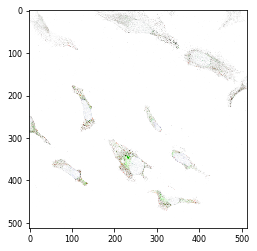

In [124]:
plt.imshow(test.get_image(test.index[100]))

In [111]:
len(test.index)

11702

In [112]:
len(train.index)

31072

In [177]:
pa.Test()

## Output Formatting

In [268]:
# Notebook Settings
%matplotlib inline

display(HTML("<style>.container { width:100% !important; }</style>"))

# Numpy Settings
np.set_printoptions(precision = 3, linewidth = 1e5, threshold = 1e5)

# Pandas Settings
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns",50)
pd.set_option("display.float_format","{:.2f}".format)



# Plot Settings
plt.rc('axes', labelsize=11)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('savefig', pad_inches = 0)
plt.rc('xticklabel')
sns.set_palette("husl",n_colors = 4)

## Data Exploration

### Class Populations

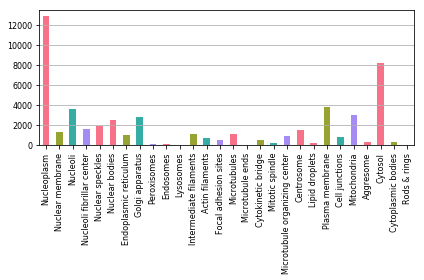

In [144]:
fig, ax = plt.subplots()
counts = train.labels.sum()
counts.plot.bar(ax = ax)
ax.yaxis.grid(True)
fig.tight_layout()
fig.savefig("plots/class_counts.pdf")

### Correlation Between Labels

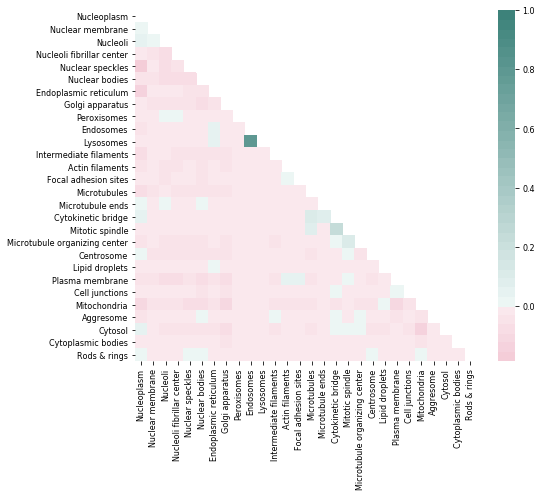

In [146]:
corr = train.labels.corr()
corr.columns = corr.index = train.classes

mask = np.zeros_like(corr.values)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize = (8,7))
sns.heatmap(corr, ax = ax, mask = mask, center = 0,
            cmap = sns.diverging_palette(0,180,sep=1,n=64))

plt.tight_layout()
plt.savefig("plots/corr.pdf")

### Number of labels per example

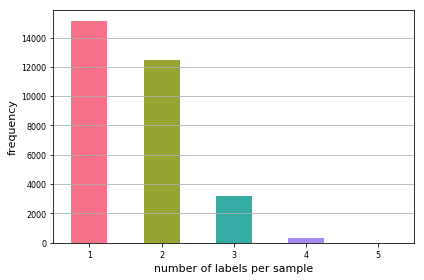

In [147]:
fig, ax = plt.subplots()
n_labels = train.labels.sum(axis = 1)
n_labels.value_counts().plot.bar(ax = ax, rot = 0)
ax.yaxis.grid()
ax.set_xlabel("number of labels per sample")
ax.set_ylabel("frequency")
fig.tight_layout()
fig.savefig("plots/label_count.pdf")

## Colormaps for Sample Images

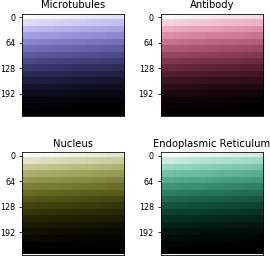

In [328]:
fig = plt.figure(figsize = (4,4))
gs = GridSpec(nrows = np.ceil(train.n_channels/2).astype(np.int32), ncols = 2,
              left = 0, bottom = 0, right = 1, top = 1)
for channel_ix in range(train.n_channels):
    ax = plt.subplot(gs[channel_ix])
    ax.imshow(np.arange(256).reshape(16,16) / 255, cmap = train.cmaps[channel_ix])
    ax.set_title(train.channels[channel_ix], fontsize = 10)
    ax.set_xticks([])
    ax.set_yticks(np.arange(4)/4*16)
    ax.set_yticklabels((np.arange(4)/4*256).astype(np.int32))

gs.tight_layout(fig)
fig.savefig("plots/colormaps.pdf", pad_inches = 0)

In [322]:
fig.get_size_inches()

array([5., 5.])

## Class Examples

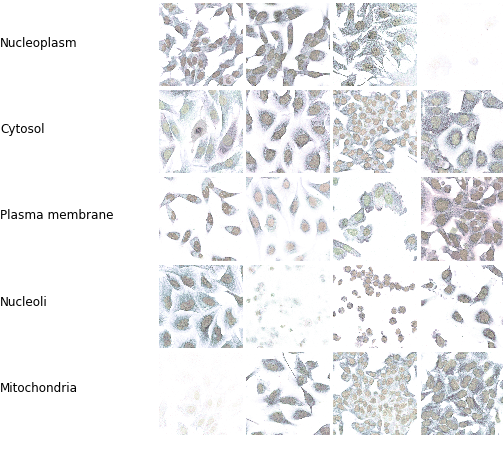

In [311]:
nrows = n_classes = 5
ncols = n_examples_per_class = 4
img_height = img_width = 1.2
label_width = 2.2

fig = plt.figure(figsize = (ncols*img_width + label_width,nrows*img_height))
gs = GridSpec(nrows,ncols, 
              hspace = 0.05, wspace = 0.05,
              left = label_width/(label_width + ncols*img_width), bottom = 0, top = 1, right = 1)

example_classes = train.labels.sum().sort_values(ascending=False).index[:n_classes]

for row_ix, class_ in enumerate(example_classes):
    ids = train.any(class_).sample(ncols).index
    imgs = train.get_images(ids)
    fig.text(0,1-(row_ix+.5)/n_classes, s = class_, fontsize = 12)
    
    # New images in RGBa
    new_imgs = np.zeros((n_examples_per_class,train.nrows,train.ncols,4))

    bands = np.split(imgs,train.n_channels,axis = 3)
    for chan_ix in range(train.n_channels):
        bands[chan_ix] = np.squeeze(bands[chan_ix],axis = 3)
        bands[chan_ix] = train.cmaps[chan_ix](bands[chan_ix])
        new_imgs = new_imgs + bands[chan_ix] / train.n_channels

    for sample_ix in range(ncols):
        img = new_imgs[sample_ix,:,:,:]
        ax = plt.subplot(gs[row_ix, sample_ix])
        ax.imshow(img)
        ax.set_axis_off()

        
fig.savefig("plots/exmples.pdf")


## Input Pipeline

In [7]:
train_gen = pa.DataGenerator(labels = atlas.train)
test_gen  = pa.DataGenerator(labels = atlas.test)

## Neural Network

### Metrics

In [10]:
def f1_score(y_true, y_pred):
    """
    Calculate the f1 score of the predictions y_pred with respect to the
    ground truth y_true.
    
    Parameters:
    
        y_true : tensor, shape (n_examples,n_classes)
        
            The true class labels.
            
        y_pred : tensor, shape (n_examples,n_classes)
        
            Predicted classes, or predicted class probabilities. Class 
            probabilities will be rounded to 0 or 1 to compute the score.
            
    Returns:
    
        f1_score : variable

Citation:
        
        Kaggle notebook of Michal Haltuf,
        https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
"""
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2*precision*recall / (precision+recall+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), K.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    """
    Calculate the f1 loss of the predictions y_pred with respect to the
    ground truth y_true.
    
    Parameters:
    
        y_true : tensor, shape (n_examples,n_classes)
        
            The true class labels.
            
        y_pred : tensor, shape (n_examples,n_classes)
        
            Predicted class probabilities.
            
    Returns:
    
        f1_loss : variable
        
    Citation:
        
        Kaggle notebook of Michal Haltuf,
        https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    """
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), K.zeros_like(f1), f1)
    return 1 - K.mean(f1)

### Model

In [11]:
reload(pa)
atlas = pa.ProteinAtlas()
train_gen = pa.DataGenerator(labels = atlas.train, batch_size = 32)
test_gen = pa.DataGenerator(labels = atlas.test, batch_size = 32)

In [18]:
def make_model(augment = False):
    inputs = Input(batch_shape = ((None,512,512,4)))

    if augment:
        ud_reflections = K.reverse(inputs,1)
        lr_reflections = K.reverse(inputs,2)
        batch = K.concatenate([inputs,ud_reflections,lr_reflections], axis = 0)
    else:
        batch = inputs
        
    #Resize:
    batch = MaxPooling2D((4,4))(batch)

    h = Conv2D(8,(3,3),activation="relu")(batch)
    h = BatchNormalization(axis = -1)(h)
    
    h = Conv2D(8,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)

    h = Conv2D(16,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)

    c1 = Conv2D(16,(3,3),padding="same",activation="relu")(h)
    c2 = Conv2D(16,(5,5),padding="same",activation="relu")(h)
    c3 = Conv2D(16,(7,7),padding="same",activation="relu")(h)
    c4 = Conv2D(16,(1,1),padding="same",activation="relu")(h)
    
    h = Concatenate()([c1,c2,c3,c4])
    h = BatchNormalization(axis=-1)(h)
    h = MaxPooling2D((2,2))(h)
    
    h = Conv2D(32,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)

    h = Conv2D(64,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)
    
    h = Conv2D(128,(3,3),activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = MaxPooling2D((2,2))(h)
    h = Dropout(0.25)(h)
    
    h = Flatten()(h)
    h = Dropout(0.5)(h)
    
    h = Dense(atlas.n_classes,activation="relu")(h)
    h = BatchNormalization(axis = -1)(h)
    h = Dropout(0.1)(h)
    
    outputs = Dense(atlas.n_classes,activation="sigmoid")(h)
    
    return Model(inputs,outputs)

In [19]:
model = make_model(augment = False)
# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = f1_loss, optimizer = Adam(1e-3))
model.summary()

history = model.fit_generator(
    train_gen,
    epochs = 1,
#     steps_per_epoch = 1 # number of batches per epoch
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 128, 128, 4)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 126, 126, 8)  296         max_pooling2d_31[0][0]           
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 126, 126, 8)  32          conv2d_51[0][0]                  
__________________________________________________________________________________________________
conv2d_52 